In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns
import random
import os

In [ ]:
#função para definir uma seed constantes
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
  
seed_everything(17)

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Aprendizado por reforço/NLP/Dataset/dataset_projeto_final.csv") #importando o dataset direto do google drive

In [ ]:
df

,text,label
0,Impossibilitado de arcar com as custas process...,Justiça gratuita
1,"Com efeito , faz jus o Autor à concessão da gr...",Justiça gratuita
2,"Como é cediço , de acordo com o referido diplo...",Justiça gratuita
3,"Por tais razões , e por imperiosa necessidade ...",Justiça gratuita
4,O Autor entabulou com o Banco Réu o Contrato d...,Financiamento veículo
...,...,...
64168,"Neste sentido , no que se refere à Tarifa de C...",Jurisprudência
64169,"Como também , tal entendimento foi pacificado ...",Jurisprudência
64170,“ A COBRANÇA A TÍTULO DE COMISSÃO DO CORRESPON...,Jurisprudência
64171,Assim já decidiu o STJ : RECURSO ESPECIAL REPE...,Jurisprudência


In [ ]:
df['label'].value_counts() #distribuição das classes

Dano moral                                   9280
Inexistência de relação jurídica/débito      8843
Jurisprudência                               4863
Tutela antecipada                            4610
Inscrição indevida                           3790
Inversão do ônus da prova                    3649
Fraude                                       3444
Qualificação                                 2832
Justiça gratuita                             2718
Falha prestação/responsabilidade objetiva    2572
Relação de consumo                           2143
Produtos bancários                           1900
Dano material                                1707
Restituição em dobro                         1623
Responsabilidade civil                       1549
Canais Internos                              1468
Valor da causa                               1330
Produção de provas                           1132
Audiência conciliação                         843
Honorários/custas                             829


In [ ]:
df['label'] = df['label'].replace(['Notificação de inscrição'], 'Inscrição indevida') #essas duas classes são parecidas, então optamos por juntá-las em uma só

In [ ]:
df['label'].value_counts() #nova distribuição das classes

Dano moral                                   9280
Inexistência de relação jurídica/débito      8843
Jurisprudência                               4863
Tutela antecipada                            4610
Inscrição indevida                           3926
Inversão do ônus da prova                    3649
Fraude                                       3444
Qualificação                                 2832
Justiça gratuita                             2718
Falha prestação/responsabilidade objetiva    2572
Relação de consumo                           2143
Produtos bancários                           1900
Dano material                                1707
Restituição em dobro                         1623
Responsabilidade civil                       1549
Canais Internos                              1468
Valor da causa                               1330
Produção de provas                           1132
Audiência conciliação                         843
Honorários/custas                             829


###Pré-processamento (limpeza dos textos e passando os labels para números)

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
top = stopwords.words('portuguese')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (top)]))
symbols = "!\"#$%&()*+-,./:´~;<=>?[\]^`{|}~\n..."
df["text"] = df["text"].str.translate({ord(symbol):"" for symbol in symbols})
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [ ]:
possible_labels = df.label.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Justiça gratuita': 0,
 'Financiamento veículo': 1,
 'Inexistência de relação jurídica/débito': 2,
 'Dano material': 3,
 'Restituição em dobro': 4,
 'Inversão do ônus da prova': 5,
 'Canais Internos': 6,
 'Dano moral': 7,
 'Inscrição indevida': 8,
 'Tutela antecipada': 9,
 'Multa diária': 10,
 'Produtos bancários': 11,
 'Fraude': 12,
 'Desvio produtivo': 13,
 'Jurisprudência': 14,
 'Qualificação': 15,
 'Benefeciário INSS': 16,
 'Relação de consumo': 17,
 'Responsabilidade civil': 18,
 'Honorários/custas': 19,
 'Produção de provas': 20,
 'Valor da causa': 21,
 'Audiência conciliação': 22,
 'Falha prestação/responsabilidade objetiva': 23,
 'Citação/contestação': 24}

In [ ]:
df['label'] = df.label.replace(label_dict)

In [ ]:
df

,text,label
0,impossibilitado arcar custas processuais pugna...,0
1,com efeito faz jus autor concessao gratuidade...,0
2,como cedico acordo referido diploma legal ba...,0
3,por tais razoes imperiosa necessidade requer...,0
4,o autor entabulou banco reu contrato financiam...,1
...,...,...
64168,neste sentido refere tarifa cadastro efetiva...,14
64169,como tal entendimento pacificado julgamento r...,14
64170,a cobranca a titulo de comissao do correspond...,14
64171,assim decidiu stj recurso especial repetitivo...,14


###Divisão entre treino e teste

In [ ]:
treino, teste = train_test_split(df, test_size=0.2, stratify = df['label'])


In [ ]:
treino.reset_index(drop=True, inplace=True)
teste.reset_index(drop=True, inplace=True)

In [ ]:
treino['data_type'] = ['train']*treino.shape[0]
teste['data_type'] = ['teste']*teste.shape[0]

In [ ]:
df = pd.concat([treino, teste], axis=0, ignore_index = True)

In [ ]:
#quantidade de dados atribuida para treino e para teste, por classe
df.groupby(['label', 'data_type']).count()

text
label data_type      
0     teste       544
      train      2174
1     teste       112
      train       449
2     teste      1769
      train      7074
3     teste       341
      train      1366
4     teste       325
      train      1298
5     teste       730
      train      2919
6     teste       294
      train      1174
7     teste      1856
      train      7424
8     teste       785
      train      3141
9     teste       922
      train      3688
10    teste       147
      train       591
11    teste       380
      train      1520
12    teste       689
      train      2755
13    teste       156
      train       622
14    teste       973
      train      3890
15    teste       566
      train      2266
16    teste        18
      train        74
17    teste       429
      train      1714
18    teste       310
      train      1239
19    teste       166
      train       663
20    teste       226
      train       906
21    teste       266
      train      1064
22    teste       169
      train       674
23    teste       514
      train      2058
24    teste       148
      train       595

###Importando o tokenizer e o modelo pré-treinado, e passando para TensorDataset

In [ ]:
#Luciano/bert-base-portuguese-cased-finetuned-peticoes

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', 
                                          do_lower_case=True)

In [ ]:
model = BertForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased",
                                                      num_labels=len(label_dict),
                                                       id2label =  {
                                                                      0: 'Justica gratuita',
                                                                      1: 'Financiamento veiculo',
                                                                      2: 'Inexistencia de relacao juridica/debito',
                                                                      3: 'Dano material',
                                                                      4: 'Restituicao em dobro',
                                                                      5: 'Inversao do onus da prova',
                                                                      6: 'Canais Internos',
                                                                      7: 'Dano moral',
                                                                      8: 'Inscricao indevida',
                                                                      9: 'Tutela antecipada',
                                                                      10: 'Multa diaria',
                                                                      11: 'Produtos bancarios',
                                                                      12: 'Fraude',
                                                                      13: 'Desvio produtivo',
                                                                      14: 'Jurisprudencia',
                                                                      15: 'Qualificacao',
                                                                      16:'Benefeciario INSS',
                                                                      17:'Relacao de consumo',
                                                                      18:'Responsabilidade civil',
                                                                      19:'Honorarios/custas',
                                                                      20:'Producao de provas',
                                                                      21: 'Valor da causa',
                                                                      22: 'Audiencia conciliacao',
                                                                      23: 'Falha prestacao/responsabilidade objetiva',
                                                                      24: 'Citacao/contestacao'},
                                                      label2id = {
                                                                      "Justica gratuita": 'Justica gratuita',
                                                                      "Financiamento veiculo": 'Financiamento veiculo',
                                                                      "Multa diaria": 'Multa diaria',
                                                                      "Produtos bancarios": 'Produtos bancarios',
                                                                      "Fraude": 'Fraude',
                                                                      "Desvio produtivo": 'Desvio produtivo',
                                                                      "Jurisprudencia": 'Jurisprudencia',
                                                                      "Qualificacao": 'Qualificacao',
                                                                      "Benefeciario INSS": 'Benefeciario INSS',
                                                                      "Relacao de consumo": 'Relacao de consumo',
                                                                      "Responsabilidade civil": 'Responsabilidade civil',
                                                                      "Honorarios/custas": 'Honorarios/custas',
                                                                      "Inexistencia de relacao juridica/debito": 'Inexistencia de relacao juridica/debito',
                                                                      "Producao de provas": 'Producao de provas',
                                                                      "Valor da causa": 'Valor da causa',
                                                                      "Audiencia conciliacao": 'Audiencia conciliacao',
                                                                      "Falha prestacao/responsabilidade objetiva": 'Falha prestacao/responsabilidade objetiva',
                                                                      "Citacao/contestacao": 'Citacao/contestacao',
                                                                      "Dano material": 'Dano material',
                                                                      "Restituicao em dobro": 'Restituicao em dobro',
                                                                      "Inversao do onus da prova": 'Inversao do onus da prova',
                                                                      "Canais Internos": 'Canais Internos',
                                                                      "Dano moral": 'Dano moral',
                                                                      "Inscricao indevida": 'Inscricao indevida',
                                                                      "Tutela antecipada": 'Tutela antecipada'}, 
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Será utilizado max_lenght de 256

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)

encoded_data_teste = tokenizer.batch_encode_plus(
    df[df.data_type=='teste'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=128, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_teste = encoded_data_teste['input_ids']
attention_masks_teste = encoded_data_teste['attention_mask']
labels_teste = torch.tensor(df[df.data_type=='teste'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_teste = TensorDataset(input_ids_teste, attention_masks_teste, labels_teste)

In [ ]:
#verificando a quantidade de dados de treino e de teste
len(dataset_train), len(dataset_teste)

(51338, 12835)

In [ ]:
#definindo alguns hiperparâmetros a serem utilizados
batchsize = 16
epochs = 4
learning_rate = 5e-5

In [ ]:
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size = batchsize)

dataloader_teste = DataLoader(dataset_teste, 
                                   sampler=SequentialSampler(dataset_teste), 
                                   batch_size = batchsize)

In [ ]:
#definindo o otimizador
optimizer = AdamW(model.parameters(),
                  lr = learning_rate)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#definindo o scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
#funções para avaliar o modelo
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
#passando o modelo para GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
#função para avaliar o modelo após o treino
def evaluate(dataset_teste):

    model.eval()
    
    loss_teste_total = 0
    predictions, true_vals = [], []
    
    for batch in dataset_teste:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_teste_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_teste_avg = loss_teste_total/len(dataset_teste) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_teste_avg, predictions, true_vals

In [ ]:
#treinamento do modelo
for epoch in tqdm(range(1, epochs+1)):   
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})        
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Loss treino: {loss_train_avg}')
    
    teste_loss, predictions, true_vals = evaluate(dataloader_teste)
    teste_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Loss teste: {teste_loss}')
    tqdm.write(f'F1 Score (Weighted): {teste_f1}')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3209 [00:00<?, ?it/s]


Epoch 1
Loss treino: 0.6712114385454853
Loss teste: 0.5019383484898958
F1 Score (Weighted): 0.8540157788573475


Epoch 2:   0%|          | 0/3209 [00:00<?, ?it/s]


Epoch 2
Loss treino: 0.39783891083730105
Loss teste: 0.49160881912519
F1 Score (Weighted): 0.8632911477190746


Epoch 3:   0%|          | 0/3209 [00:00<?, ?it/s]


Epoch 3
Loss treino: 0.2724644812215764
Loss teste: 0.5301552513726798
F1 Score (Weighted): 0.8664269193020675


Epoch 4:   0%|          | 0/3209 [00:00<?, ?it/s]


Epoch 4
Loss treino: 0.17534051368264936
Loss teste: 0.5974790952968669
F1 Score (Weighted): 0.8688509491701201


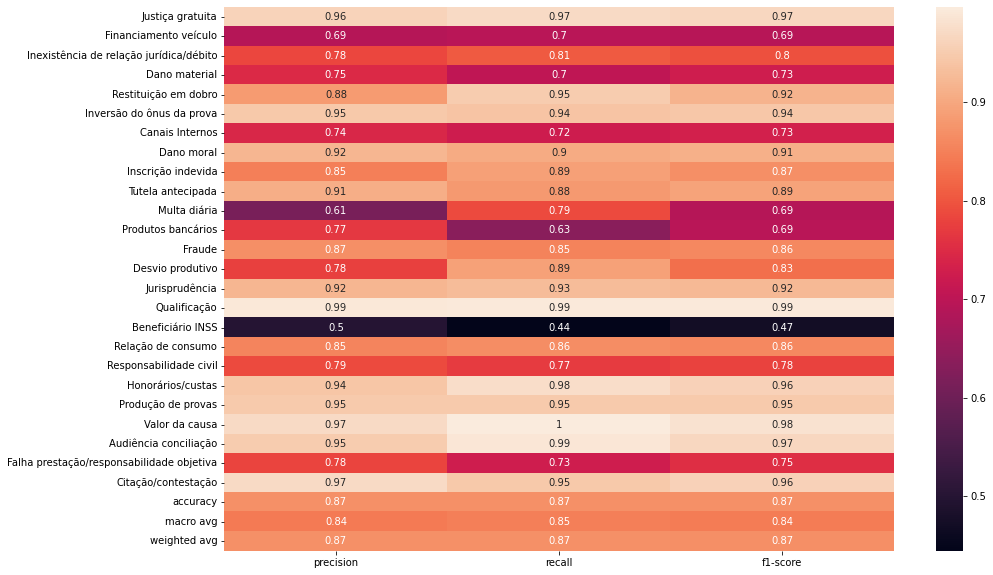

In [ ]:
predições = np.argmax(predictions, axis=1).flatten()
labels_originais = true_vals.flatten()

clf_report = classification_report(labels_originais, predições, target_names=['Justiça gratuita', 'Financiamento veículo', 'Inexistência de relação jurídica/débito', 
                                           'Dano material', 'Restituição em dobro', 'Inversão do ônus da prova', 'Canais Internos', 
                                           'Dano moral', 'Inscrição indevida', 'Tutela antecipada', 'Multa diária', 'Produtos bancários', 'Fraude', 
                                           'Desvio produtivo', 'Jurisprudência', 'Qualificação', 'Beneficiário INSS', 'Relação de consumo', 'Responsabilidade civil',
                                           'Honorários/custas', 'Produção de provas', 'Valor da causa', 'Audiência conciliação', 'Falha prestação/responsabilidade objetiva',
                                           'Citação/contestação'], output_dict=True)

fig, ax = plt.subplots(figsize=(15, 10))
plot = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax)